In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image

import os.path, sys
sys.path.append(os.path.pardir)

from drunkenmarkov.Analysis import MarkovStateModel, TransitionPathTheory
from drunkenmarkov import Clustering
from drunkenmarkov.clustering import kmeans
from drunkenmarkov.Estimation import estimate_reversible, cmatrix
from drunkenmarkov.Visualization import draw_graph, draw_stationary, draw_graph_dominant, draw_spectrum


%matplotlib inline

## Data Input ##

In [2]:
data = np.loadtxt('../drunkenmarkov/data/example_1.dat')

## Visualization ##

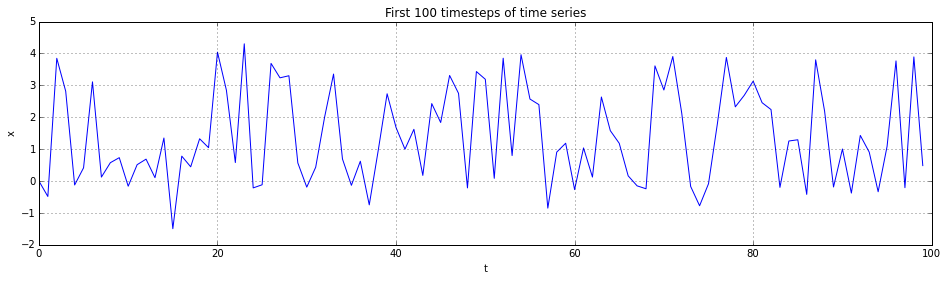

In [3]:
plt.figure(figsize=(16,4))

plt.xlabel('t')
plt.ylabel('x')
plt.title('First 100 timesteps of time series')

plt.grid()

_ = plt.plot(data[0:100])

In [4]:
def U(x):
    _x = x - 2.
    return _x**4 - 6. * _x**2 + 2. * _x

In [5]:
hist, edge = np.histogram(data, bins=100)

x = np.linspace(np.min(data), np.max(data), 10000)
y = U(x)

In [6]:
def twinx_plot(ax1, alphamapper=lambda x: 0.5, colormapper=lambda x: 'r'):
    ax1.plot(x, y, 'b-')
    ax1.set_xlabel('x')
    ax1.set_ylabel('U', color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
        
    width = 0.7 * (edge[1] - edge[0])
    center = (edge[:-1] + edge[1:]) / 2

    ax2 = ax1.twinx()
    for (index, bar) in enumerate(hist):
        ax2.bar(center[index], hist[index], align='center', width=width, alpha=alphamapper(index), color=colormapper(index))
    ax2.set_ylabel('Count', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
        
    ax1.legend(['U(x)'], loc=2)
    ax2.legend(['Density Histogram'], loc=0)
    
    plt.grid()
        
    return (ax1, ax2)

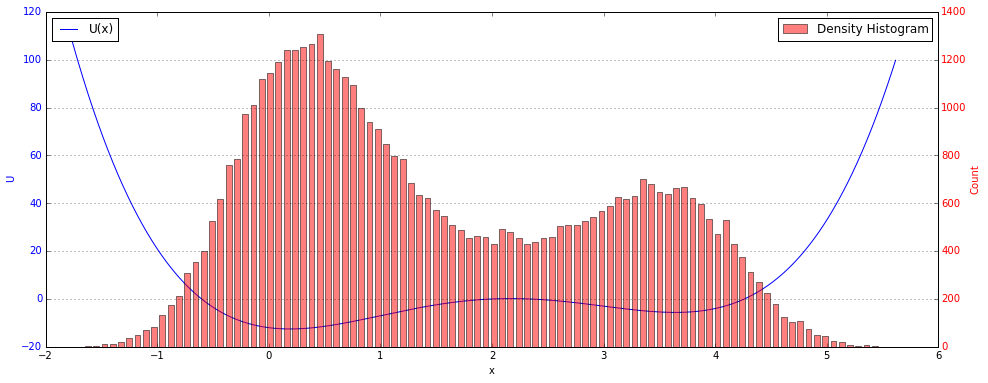

In [7]:
fig, ax1 = plt.subplots(figsize=(16, 6))
_ = twinx_plot(ax1)

## Clustering ##

In [8]:
clusters = Clustering.cluster(data, algorithm = kmeans.KMeans(k = 10, n_runs=1))

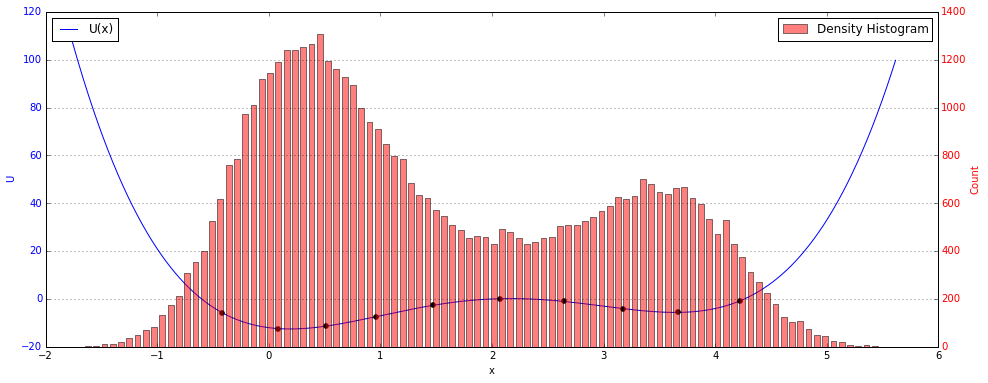

In [9]:
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1, ax2 = twinx_plot(ax1)

for i in range(len(clusters.centers)):
    ax1.plot(clusters.centers[i], U(np.array(clusters.centers).flatten())[i], 'ko', markersize=5)

In [10]:
discrete_trajectory = clusters.getDataMapping()

In [11]:
center = (edge[:-1] + edge[1:]) / 2

def get_nearest_cluster(ind, center):
    return np.argmin(np.sqrt(np.power(center[ind] - clusters.getClusterCenters(), 2)))

def get_nearest_reduced_state(ind, center):
    return np.argmin(membership[get_nearest_cluster(ind, center), :])

def get_assignment_probability(ind, center):
    return np.max(probabilities[get_nearest_cluster(ind, center)])

def map_discrete_trajectory_to_position(discrete_trajectory, mini, maxi):
    return [clusters.getClusterCenters()[discrete_trajectory[t]] for t in range(mini, maxi)]

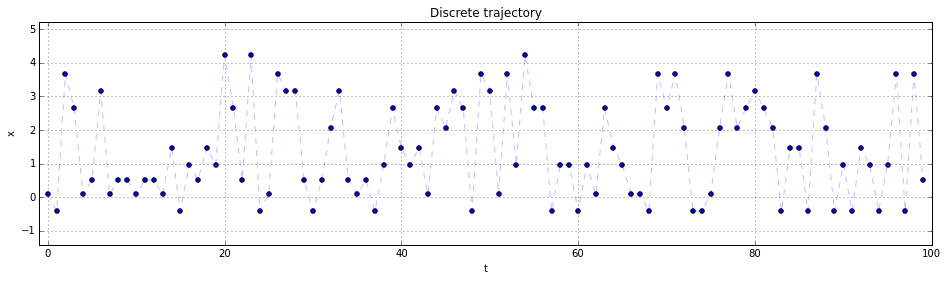

In [12]:
plt.figure(figsize=(16,4))

x_discrete = map_discrete_trajectory_to_position(discrete_trajectory, 0, 100)

plt.xlabel('t')
plt.ylabel('x')

plt.xlim([-1, 100])
plt.ylim([min(x_discrete) - 1, max(x_discrete) + 1])

plt.title('Discrete trajectory')

plt.grid()

_ = plt.scatter(np.linspace(0, 99, 100), map_discrete_trajectory_to_position(discrete_trajectory, 0, 100))
_ = plt.plot(np.linspace(0, 99, 100), map_discrete_trajectory_to_position(discrete_trajectory, 0, 100), '--', alpha=0.25)

## Estimation ##

In [14]:
cmat = cmatrix(discrete_trajectory)
T = estimate_reversible(cmat)

In [15]:
def plot_transition_matrix(T):
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.set_title('Transition Matrix')

    tplot = ax.pcolor(T)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    _ = fig.colorbar(tplot, cax=cbar_ax)

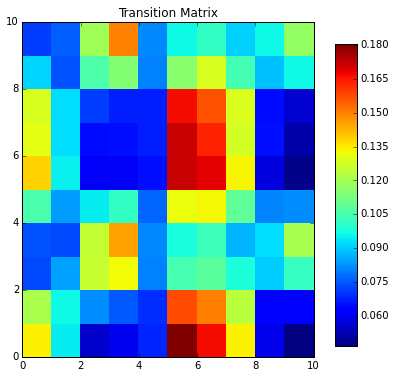

In [16]:
plot_transition_matrix(T)

## Analysis ##

In [17]:
MSM = MarkovStateModel(T)

In [35]:
MSM.is_connected

True

In [30]:
MSM.period

This Markov chain is aperiodic and converges to its stationary distribution


1.0

In [37]:
MSM.is_reversible

True

In [36]:
MSM.timescales

array([        inf,  0.68597611,  0.25166172,  0.22694116,  0.22211063,
        0.20066232,  0.19003271,  0.18036181,  0.17834249,  0.14938393])

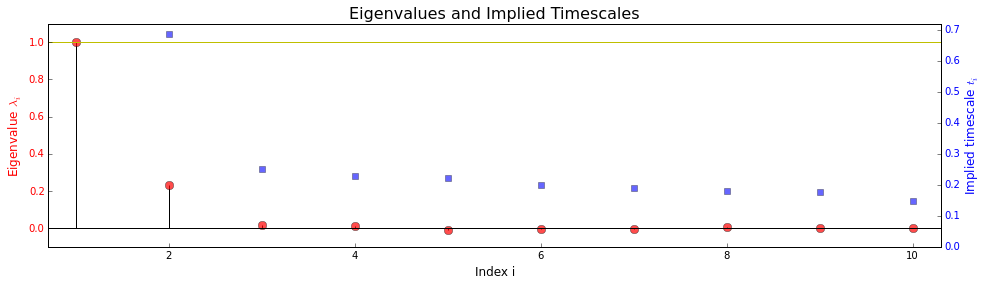

In [18]:
plt.figure(figsize=(16,4))

draw_spectrum(MSM)

In [19]:
graph = draw_graph(MSM, edge_threshold=0.02)

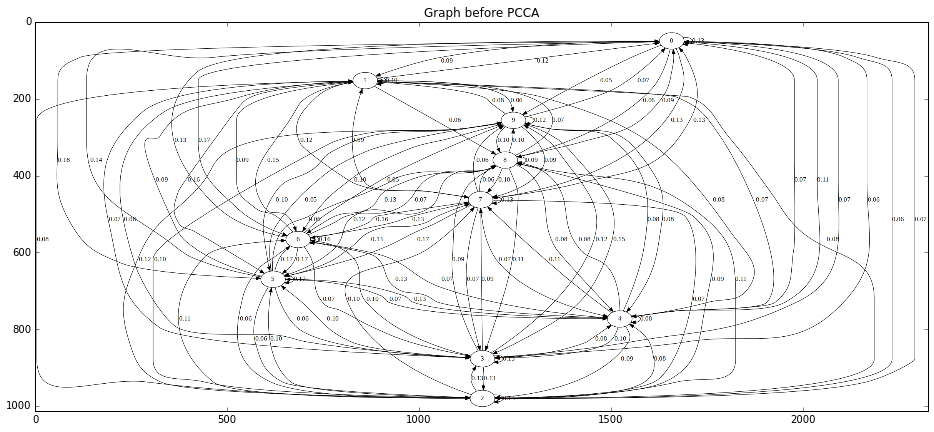

In [20]:
fig, ax = plt.subplots(figsize=(16, 16))

plt.title('Graph before PCCA')

_ = plt.imshow(np.asarray(graph))

## PCCA ##

In [21]:
(T_reduced, membership, probabilities) = MSM.reduce_matrix(2)

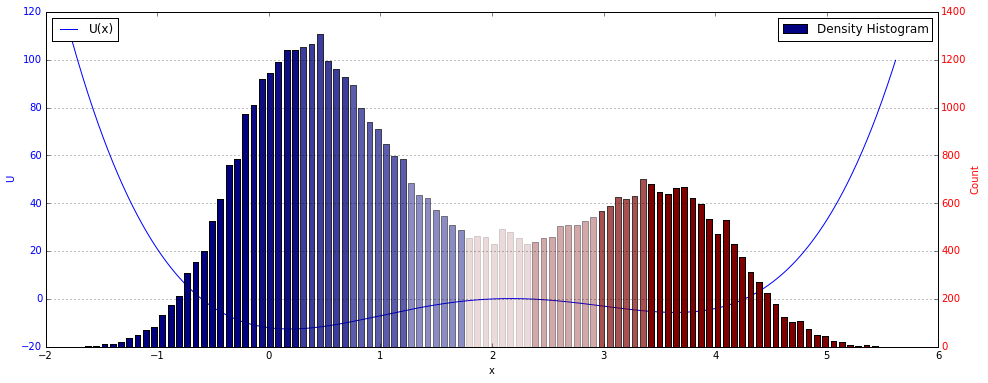

In [22]:
colormap = matplotlib.cm.get_cmap('jet', T_reduced.shape[0])

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1, ax2 = twinx_plot(ax1, 
                      colormapper=lambda x: colormap(get_nearest_reduced_state(x, center)),
                      alphamapper=lambda x: np.power(get_assignment_probability(x, center), 3))

In [23]:
MSM_reduced = MarkovStateModel(T_reduced)

In [24]:
graph = draw_graph(MSM_reduced, edge_threshold=0.02)

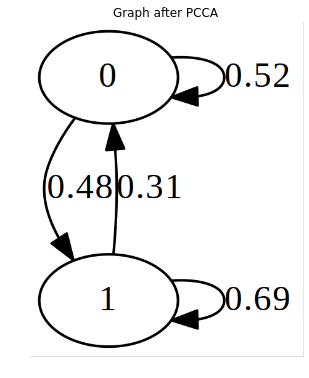

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.title('Graph after PCCA')

ax.imshow(np.asarray(graph))
_ = ax.axis('off')

## Transition Path Theory ##

In [26]:
tpt = TransitionPathTheory(T_reduced, [0], [1])

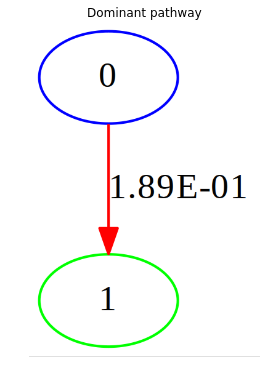

In [27]:
graph = draw_graph_dominant(tpt)

fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(np.asarray(graph))
ax.axis('off')
_ = ax.set_title('Dominant pathway')

In [28]:
print('Mean first passage time: %.2f' % tpt.mean_first_passage_time)

Mean first passage time: 2.08


In [132]:
clusters = Clustering.cluster(data, algorithm = kmeans.KMeans(k = 5, n_runs=1))

In [133]:
discrete_trajectory = clusters.getDataMapping()
cmat = cmatrix(discrete_trajectory)
T = estimate_reversible(cmat)

MSM = MarkovStateModel(T)
(T_reduced, membership, probabilities) = MSM.reduce_matrix(2)

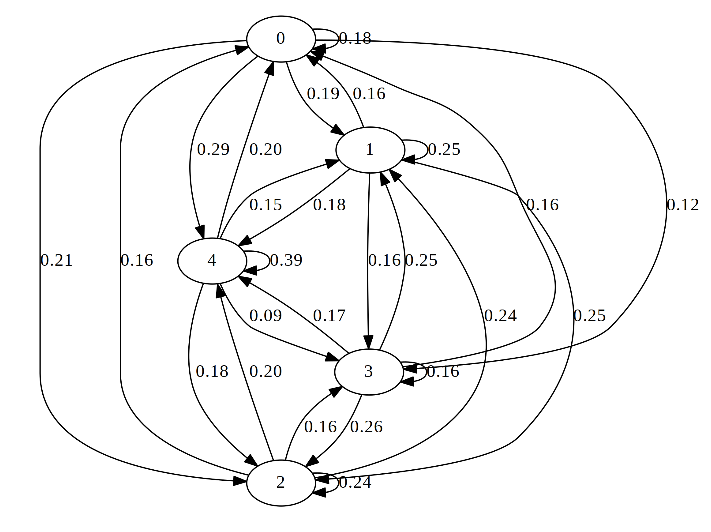

In [134]:
graph = draw_graph(MSM, edge_threshold=0.02)

fig, ax = plt.subplots(figsize=(12, 12))

ax.axis('off')
_ = plt.imshow(np.asarray(graph))

In [135]:
def get_assignments(reduced_id):
    return np.where(np.argmax(membership, axis=1) == reduced_id)[0].tolist()

In [136]:
tpt = TransitionPathTheory(T, get_assignments(0), get_assignments(1))

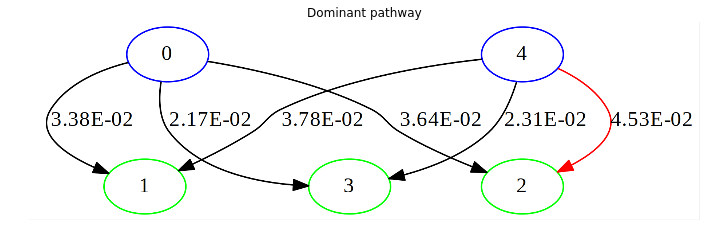

In [137]:
graph = draw_graph_dominant(tpt)

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(np.asarray(graph))
ax.axis('off')
_ = ax.set_title('Dominant pathway')

In [138]:
tpt = TransitionPathTheory(T, get_assignments(1), get_assignments(0))

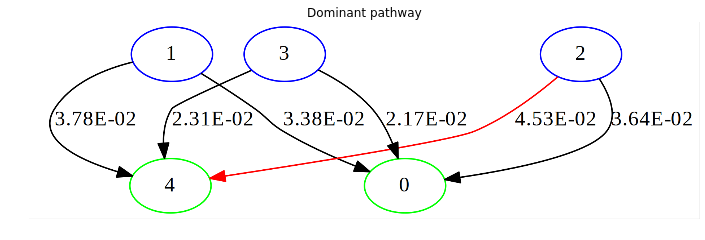

In [139]:
graph = draw_graph_dominant(tpt)

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(np.asarray(graph))
ax.axis('off')
_ = ax.set_title('Dominant pathway')